# Cosmology with one galaxy using mixture density networks

The goal of this notebook is to reproduce the results of the paper "Cosmology with 1 galaxy". We are going to use the CAMELS simulation suite to estimate the matter density of the universe ($\Omega_{M}$) uisng observable properties of galaxies.

Before starting the notebook, you can read about the CAMELS simualtion.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import cosmo_1_galaxy
import tensorflow_probability as tfp
import seaborn as sns
import os


# Check for TensorFlow GPU access
print(
    f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

tf.config.experimental.set_visible_devices([], "GPU")

# Check for TensorFlow GPU access
print(
    f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)

# import h5py

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Part 3: Apply TNG model to SIMBA

We now apply the model to the SIMBA cosmological simulation

In [276]:
tng_data = "cosmo_1_galaxy:1.0.0"
simba_data = "cosmo_1_galaxy:1.0.1"

data_dir = "/home/jovyan/tensorflow_datasets"

dset_train = tfds.load(simba_data, split="train", data_dir=data_dir)
dset_test = tfds.load(simba_data, split="test", data_dir=data_dir)
dset_valid = tfds.load(simba_data, split="valid", data_dir=data_dir)

2023-08-22 09:16:29.881169: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 09:16:29.924990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 09:16:29.959425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

<Figure size 800x600 with 0 Axes>

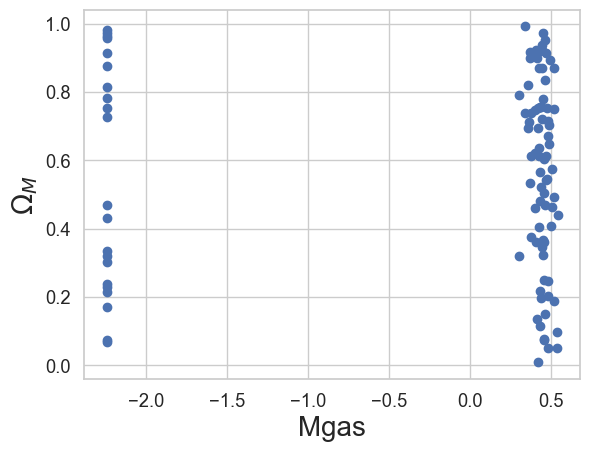

<Figure size 800x600 with 0 Axes>

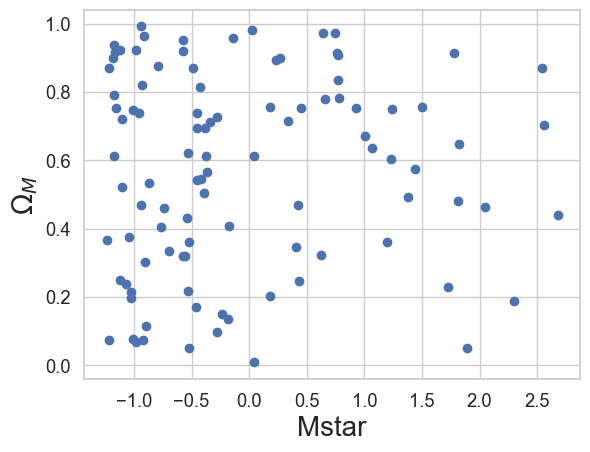

<Figure size 800x600 with 0 Axes>

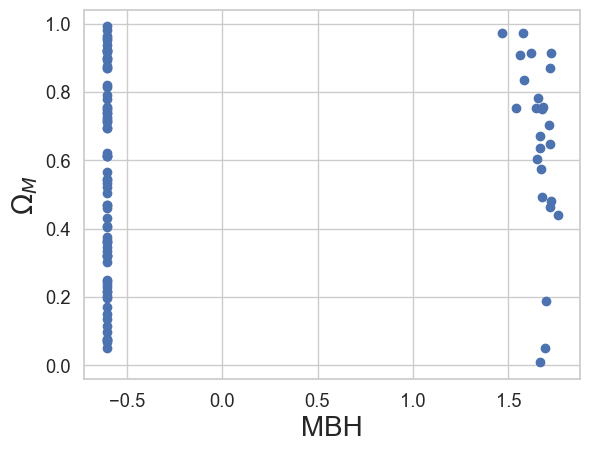

<Figure size 800x600 with 0 Axes>

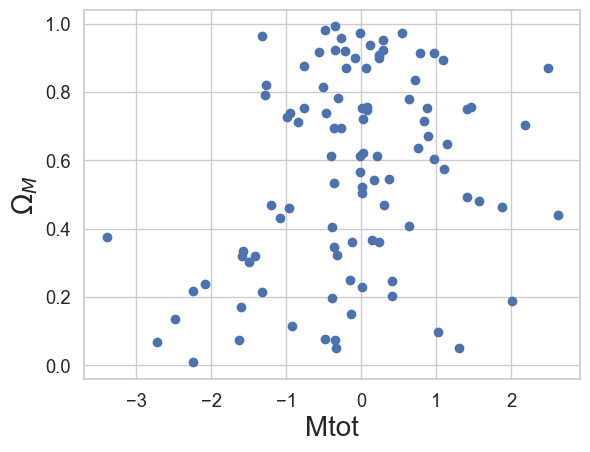

<Figure size 800x600 with 0 Axes>

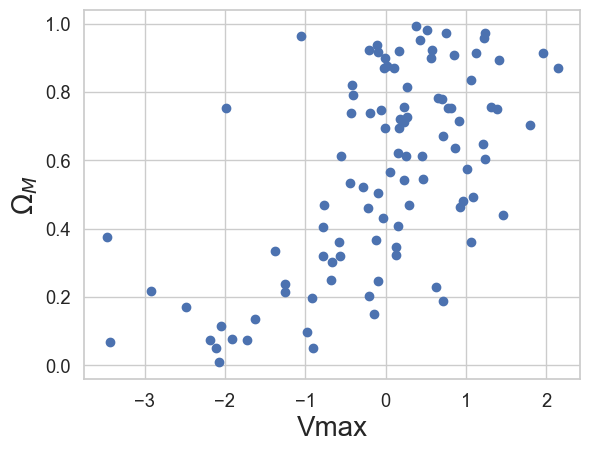

<Figure size 800x600 with 0 Axes>

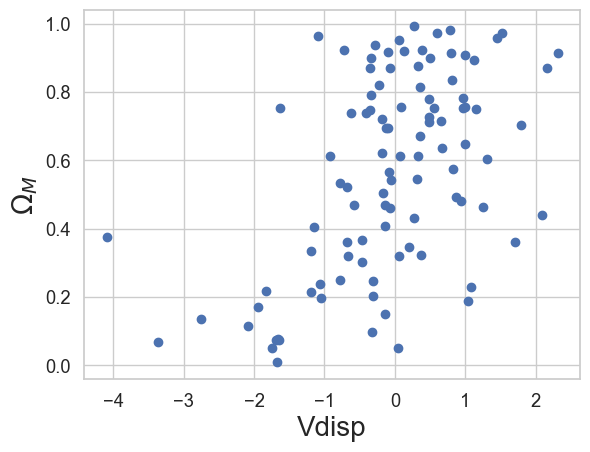

<Figure size 800x600 with 0 Axes>

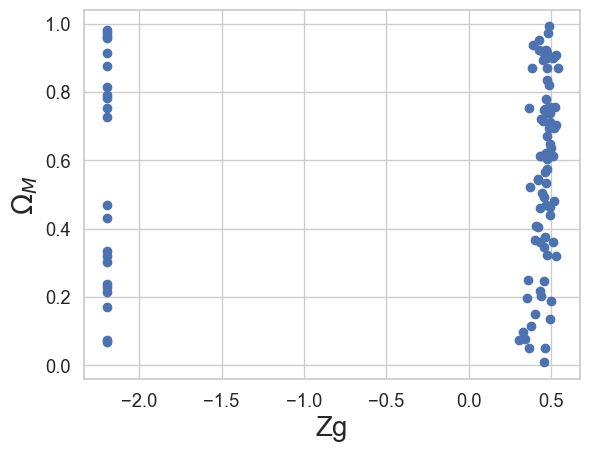

<Figure size 800x600 with 0 Axes>

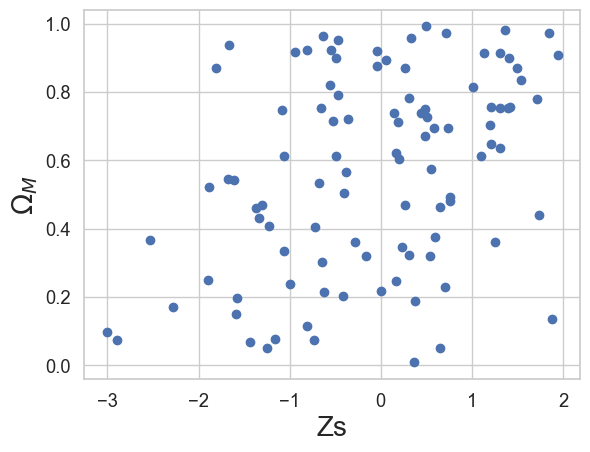

<Figure size 800x600 with 0 Axes>

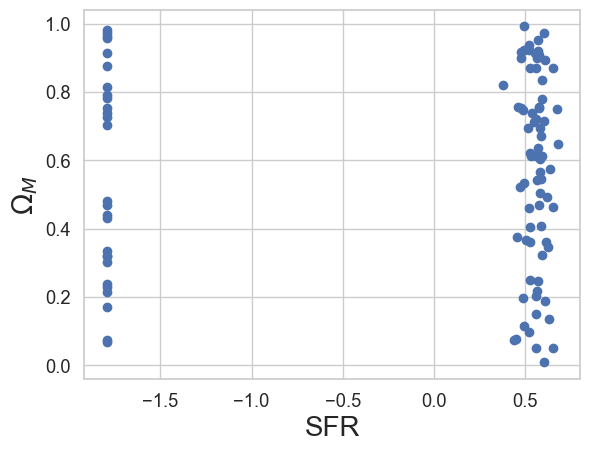

<Figure size 800x600 with 0 Axes>

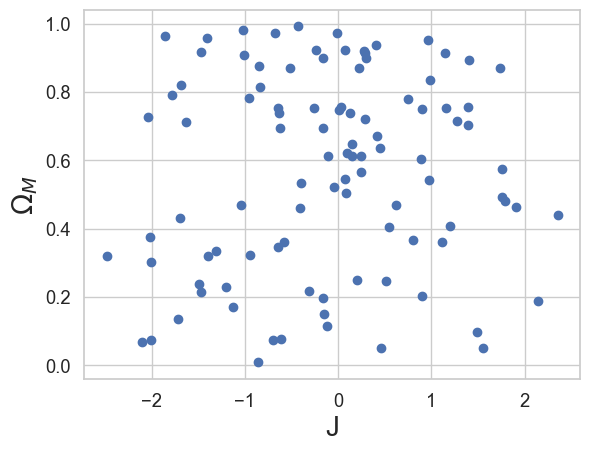

<Figure size 800x600 with 0 Axes>

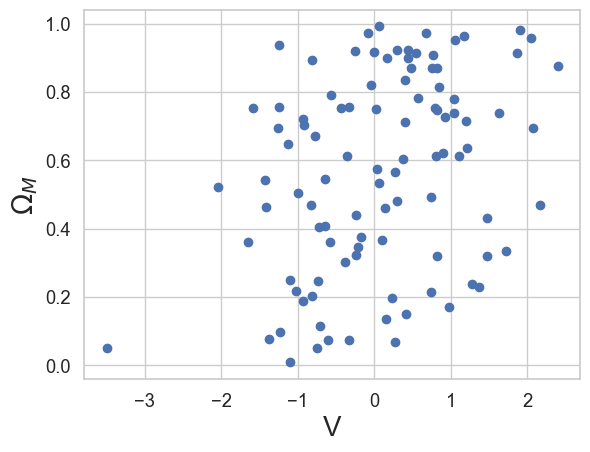

<Figure size 800x600 with 0 Axes>

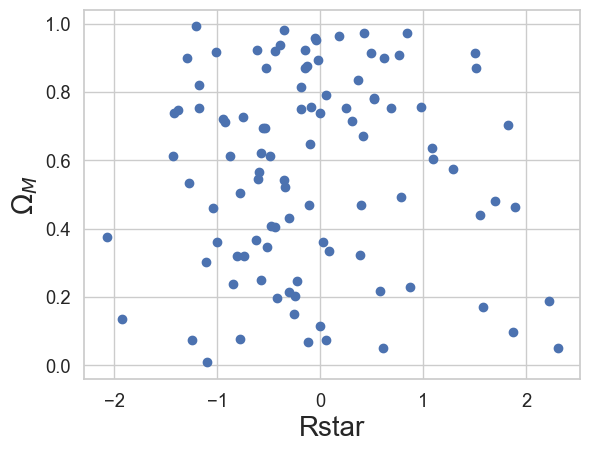

<Figure size 800x600 with 0 Axes>

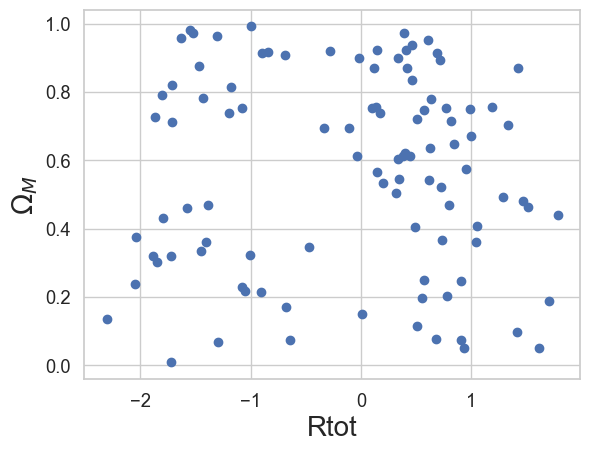

<Figure size 800x600 with 0 Axes>

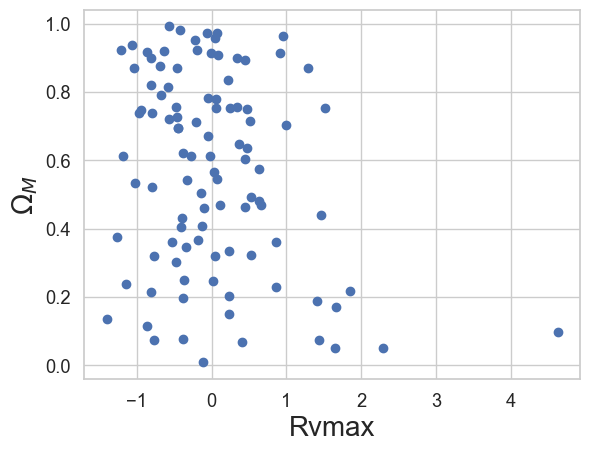

<Figure size 800x600 with 0 Axes>

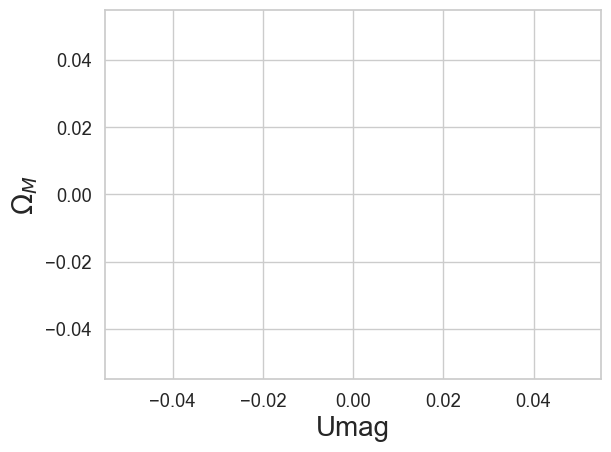

<Figure size 800x600 with 0 Axes>

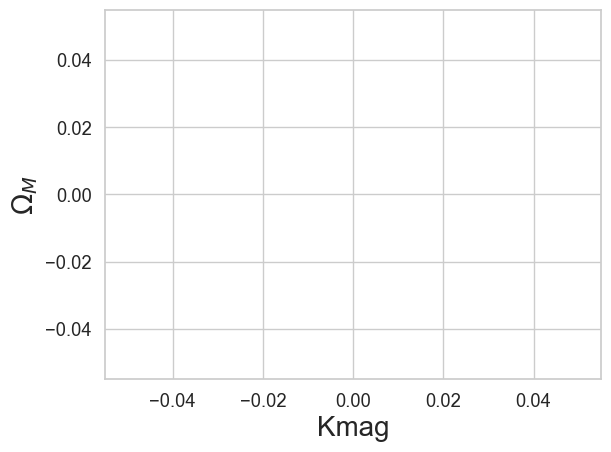

<Figure size 800x600 with 0 Axes>

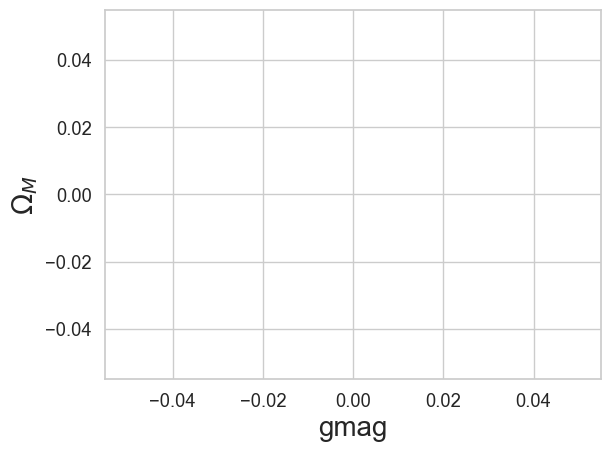

In [277]:
galprop = [
    "Mgas",
    "Mstar",
    "MBH",
    "Mtot",
    "Vmax",
    "Vdisp",
    "Zg",
    "Zs",
    "SFR",
    "J",
    "V",
    "Rstar",
    "Rtot",
    "Rvmax",
    "Umag",
    "Kmag",
    "gmag",
]
cosmo = [
    "$\Omega_M$",
    "$\sigma_8$",
    "$A_{SN1}$",
    "$A_{SN2}$",
    "$A_{AGN1}$",
    "$A_{AGN2}$",
]


# ,"Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]

cosmo_ind = 0  # this contains omega matter


for galprop_ind, lbl in zip(range(len(galprop)), galprop):
    galpropvec = []

    cosmovec = []
    for example in dset_train.take(100):
        galpropvec.append(example["input"][galprop_ind].numpy())
        cosmovec.append(example["output"][cosmo_ind].numpy())
    # print(example['output'][0])
    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(galpropvec, cosmovec)
    plt.xlabel(lbl, fontsize=20)
    plt.ylabel(cosmo[cosmo_ind], fontsize=20)

In [285]:
# [0,1,2,6,7,8,9,10,11,14,15,16]

def preprocessing(x, y, features):
    galprop = x
    cosmo = y[:, 0:1]
    return galprop, cosmo


def input_fn(
    mode="train", batch_size=64, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
):
    """
    mode: 'train', test' or 'val'
    """
    keys = ["input", "output"]
    if mode == "train":
        dataset = tfds.load(
            simba_data, split="train", data_dir=data_dir
        )
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        # filter_no_nan = lambda x,y: (tf.reduce_all(~tf.math.is_nan(x)))
        # dataset = dataset.filter(filter_no_nan)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "val":
        dataset = tfds.load(
            simba_data, split="train", data_dir=data_dir
        )
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "test":
        dataset = tfds.load(
            simba_data, split="train", data_dir=data_dir
        )
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.map(preprocessing)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [290]:
# Clear the cache for the dataset (replace 'cosmo_1_galaxy' with the actual dataset name)
# Clear the dataset cache for the specific version


# cache_base_dir = "/Users/marchuertascompany/Documents/python_scripts/camels/cache"  # Replace with the desired base cache directory
# version = "1.0.1"
# cache_dir = os.path.join(cache_base_dir, "cosmo_1_galaxy", version)
# tfds.core.download.download_manager._tfds_dir = cache_dir

dset_SIMBA = input_fn(mode="test")
omega_pred_mean = np.concatenate([mdn(batch[0]).mean() for batch in dset_SIMBA])
omega_pred_std = np.concatenate([mdn(batch[0]).stddev() for batch in dset_SIMBA])

print(omega_pred_mean)

omega_SIMBA = []
dset_test = tfds.load("cosmo_1_galaxy:" + version, split="train", data_dir=data_dir)
for example in dset_SIMBA.take(-1):
    omega_SIMBA.append(example["output"][0].numpy())


# Create a line plot using Seaborn
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(omega_SIMBA[0:100]),
    np.squeeze(omega_pred_mean[0:100]),
    yerr=np.squeeze(omega_pred_std[0:100]),
    color="gray",
    fmt="none",
)
plt.scatter(omega_SIMBA[0:100], omega_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\Omega_M$ True", fontsize=20)
plt.ylabel("$\Omega_M$ Pred", fontsize=20)

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red", ls=":")

KeyboardInterrupt: 

# Part 4: Estimate $\sigma_8$ and $\Omega_{M}$ with a Multivariate Gaussian

We need to modify the function that creates the input data to include 

In [142]:
def preprocessing(x, y):
    galprop = x
    cosmo = y[:, 0:2]  # we now include omega_m and sigma_8 here
    return galprop, cosmo


def input_fn_omega_sigma8(mode="train", batch_size=64):
    """
    mode: 'train', test' or 'val'
    """
    keys = ["input", "output"]
    if mode == "train":
        dataset = tfds.load("cosmo_1_galaxy", split="train", data_dir=data_dir)
        dataset = dataset.map(lambda x: (x["input"], x["output"]))
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "val":
        dataset = tfds.load("cosmo_1_galaxy", split="valid", data_dir=data_dir)
        dataset = dataset.map(lambda x: (x["input"], x["output"]))
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "test":
        dataset = tfds.load("cosmo_1_galaxy", split="test", data_dir=data_dir)
        dataset = dataset.map(lambda x: (x["input"], x["output"]))
        dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.map(preprocessing)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [143]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers

num_components = 1
event_shape = 2

params_size = tfp.layers.MultivariateNormalTriL.params_size(event_shape)

mdn_multivariate = tf.keras.Sequential(
    [
        tfkl.Input(shape=(12)),
        tfkl.Dense(1022, activation="LeakyReLU"),
        tfkl.Dropout(0.5277883627689858),
        tfkl.Dense(975, activation="LeakyReLU"),
        tfkl.Dropout(0.20184706977545483),
        tfkl.Dense(1311, activation="LeakyReLU"),
        tfkl.Dropout(0.5022290156424203),
        tfkl.Dense(units=params_size, activation=None),
        tfp.layers.MultivariateNormalTriL(event_shape),
    ]
)

negloglik = lambda y, p_y: -p_y.log_prob(y)


opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
mdn_multivariate.compile(loss=negloglik, optimizer=opt)

In [144]:
dset_train = input_fn_omega_sigma8()
dset_val = input_fn_omega_sigma8(mode="val")
history = mdn_multivariate.fit(
    dset_train, validation_data=dset_val, epochs=20, steps_per_epoch=3000
)

Epoch 1/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4638 - val_loss: 0.0668
Epoch 2/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0976 - val_loss: -0.0306
Epoch 3/20
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0396 - val_loss: -0.0596
Epoch 4/20
3000/3000 [==============================] - 3s 922us/step - loss: 0.0130 - val_loss: -0.1000
Epoch 5/20
3000/3000 [==============================] - 3s 865us/step - loss: -0.0076 - val_loss: -0.1143
Epoch 6/20
3000/3000 [==============================] - 3s 860us/step - loss: -0.0274 - val_loss: -0.1354
Epoch 7/20
3000/3000 [==============================] - 3s 859us/step - loss: -0.0351 - val_loss: -0.1458
Epoch 8/20
3000/3000 [==============================] - 3s 874us/step - loss: -0.0459 - val_loss: -0.1739
Epoch 9/20
3000/3000 [==============================] - 3s 863us/step - loss: -0.0595 - val_loss: -0.1655
Epoch 10/20
3000/3000 [==============================] - 

Plot the results

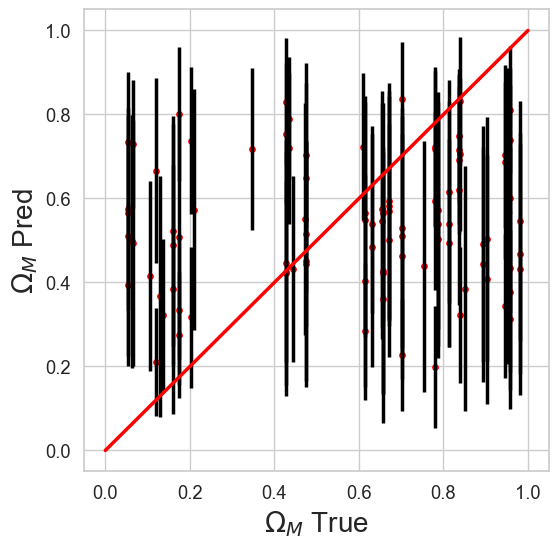

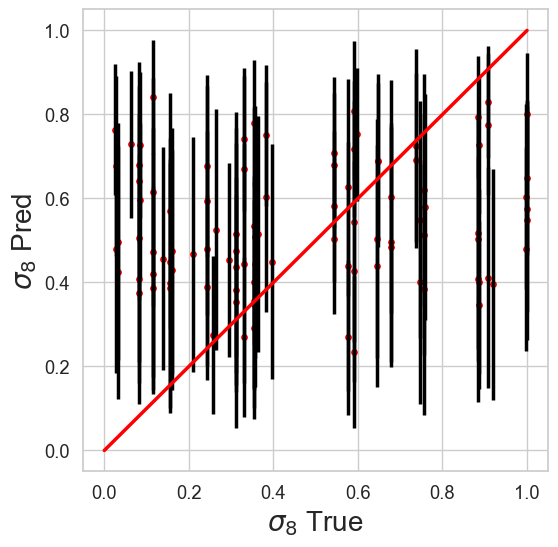

In [146]:
dset_test = input_fn_omega_sigma8(mode="test")
omega_pred_mean = np.concatenate(
    [mdn_multivariate(batch[0]).mean()[0] for batch in dset_test]
)
omega_pred_std = np.concatenate(
    [mdn_multivariate(batch[0]).stddev()[0] for batch in dset_test]
)

sigma8_pred_mean = np.concatenate(
    [mdn_multivariate(batch[0]).mean()[1] for batch in dset_test]
)
sigma8_pred_std = np.concatenate(
    [mdn_multivariate(batch[0]).stddev()[1] for batch in dset_test]
)


omega_test = []
sigma8_test = []
dset_test = tfds.load("cosmo_1_galaxy", split="test", data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example["output"][0].numpy())
    sigma8_test.append(example["output"][1].numpy())


sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(omega_test[0:100]),
    np.squeeze(omega_pred_mean[0:100]),
    yerr=np.squeeze(omega_pred_std[0:100]),
    color="black",
    fmt="none",
)
plt.scatter(omega_test[0:100], omega_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\Omega_M$ True", fontsize=20)
plt.ylabel("$\Omega_M$ Pred", fontsize=20)
plt.show()

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(sigma8_test[0:100]),
    np.squeeze(sigma8_pred_mean[0:100]),
    yerr=np.squeeze(sigma8_pred_std[0:100]),
    color="black",
    fmt="none",
)
plt.scatter(sigma8_test[0:100], sigma8_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\sigma_8$ True", fontsize=20)
plt.ylabel("$\sigma_8$ Pred", fontsize=20)
plt.show()

Plot some posterior distributions

2023-08-20 16:49:42.604946: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 800x600 with 0 Axes>

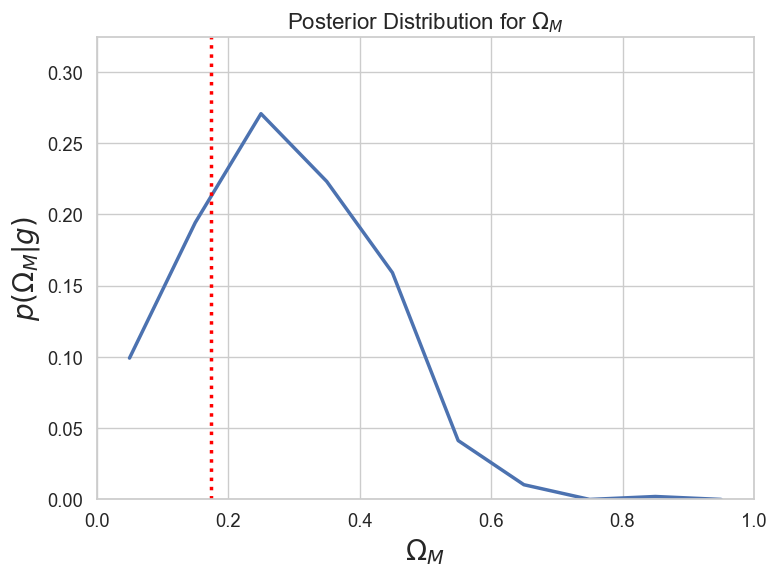

<Figure size 800x600 with 0 Axes>

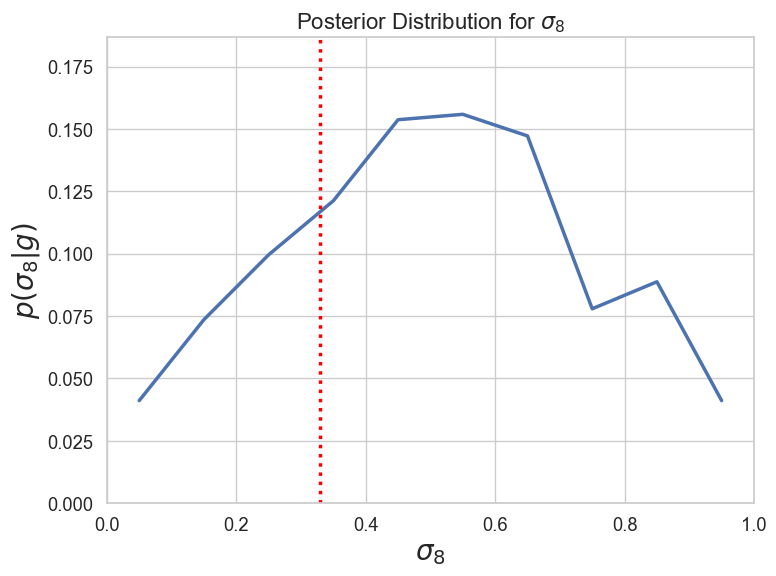

<Figure size 800x600 with 0 Axes>

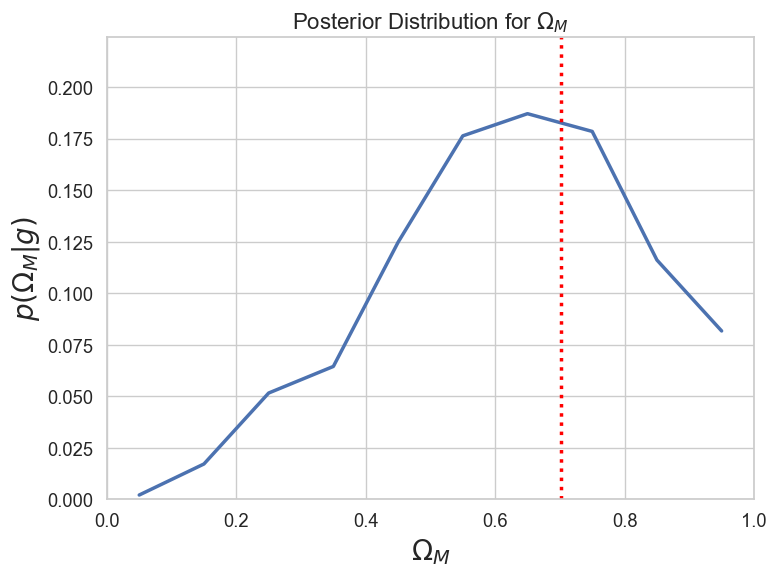

<Figure size 800x600 with 0 Axes>

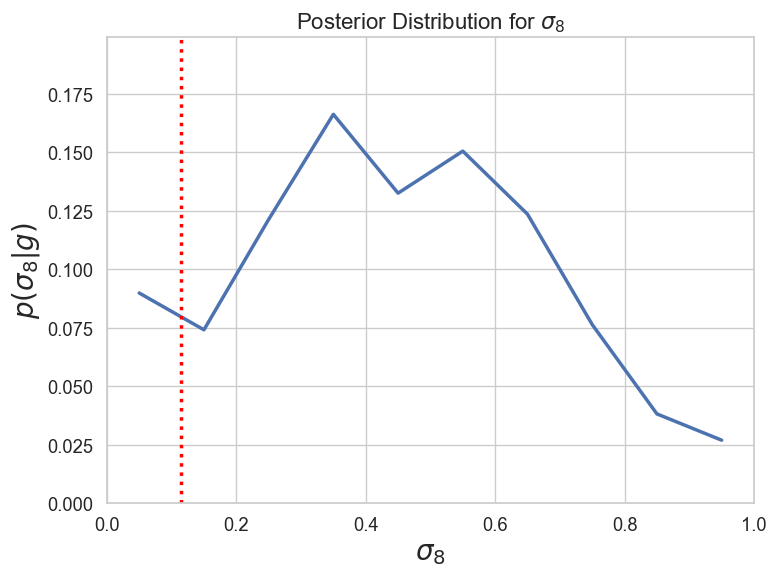

<Figure size 800x600 with 0 Axes>

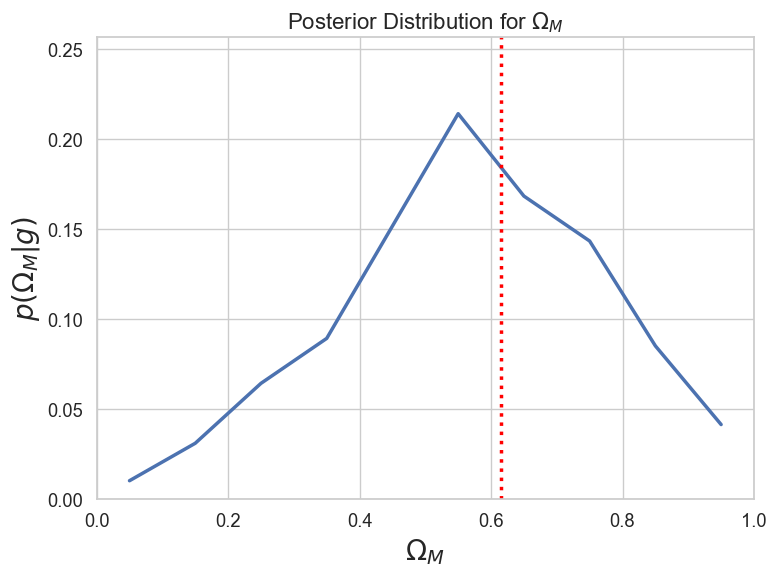

<Figure size 800x600 with 0 Axes>

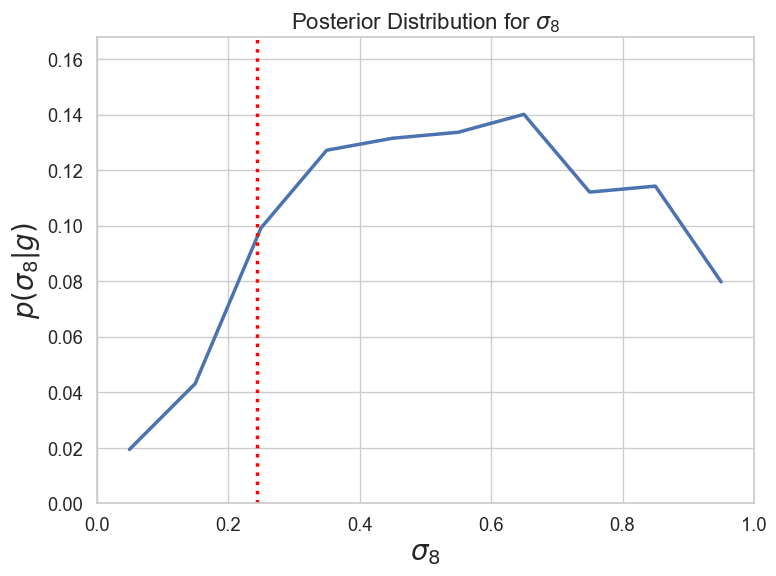

<Figure size 800x600 with 0 Axes>

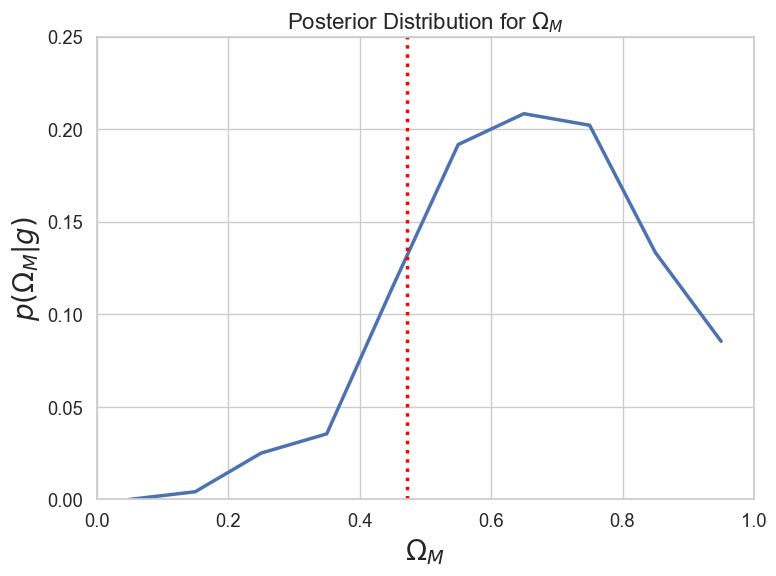

<Figure size 800x600 with 0 Axes>

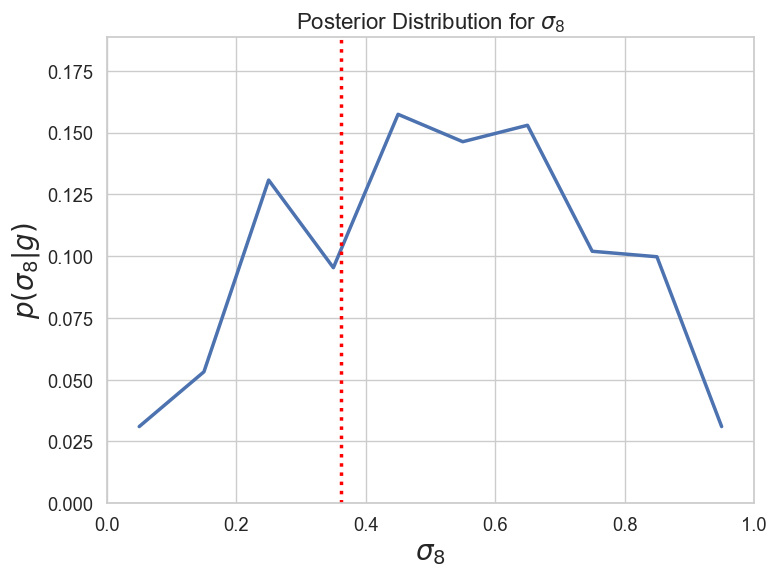

<Figure size 800x600 with 0 Axes>

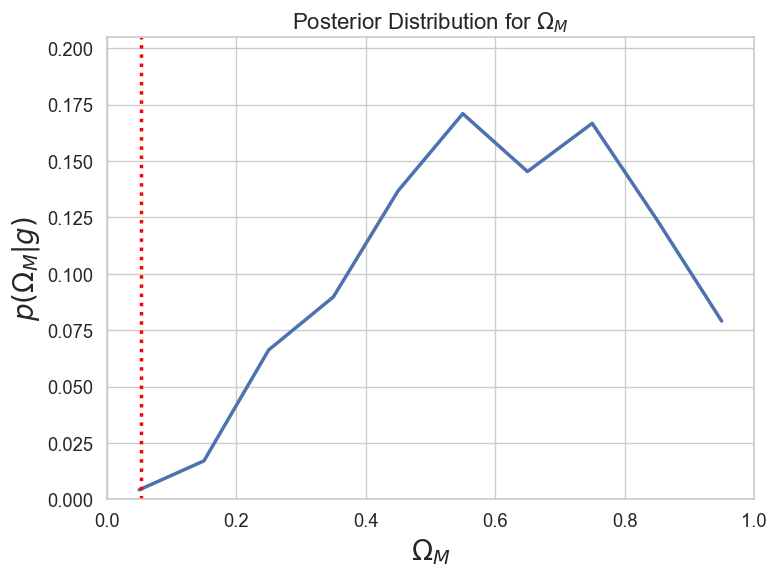

<Figure size 800x600 with 0 Axes>

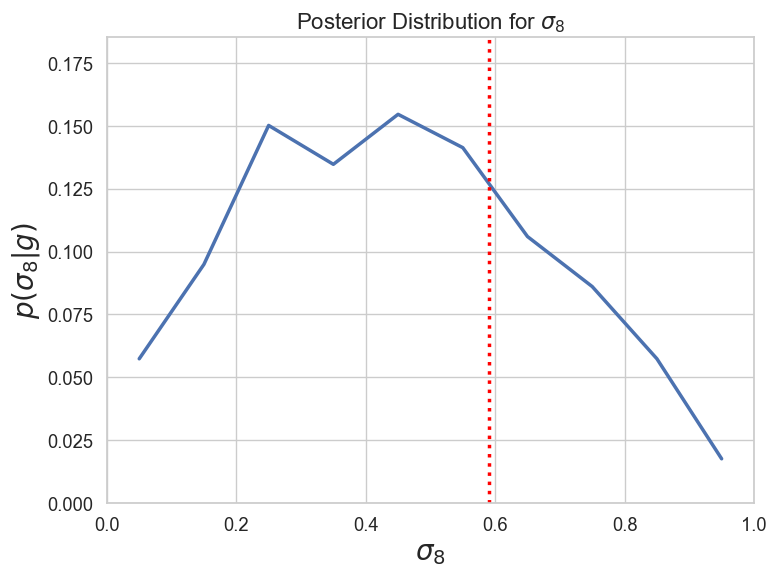

In [147]:
import seaborn as sns

dset_test = input_fn_omega_sigma8(mode="test")
iterator = iter(dset_test)

nexamples = 1
for b in range(nexamples):
    batch = iterator.get_next()
    nsamples = 500
    omega_pred_samples = []
    sigma8_pred_samples = []
    for i in range(nsamples):
        omega_pred_samples.append((mdn_multivariate(batch[0]).sample())[b, 0])
        sigma8_pred_samples.append((mdn_multivariate(batch[0]).sample())[b, 1])

    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(
        np.squeeze(np.array(omega_pred_samples)), bins=10, density=True, range=(0, 1)
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\Omega_M$", fontsize=20)
    plt.ylabel(r"$p(\Omega_M|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\Omega_M$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    plt.axvline(x=batch[1][b, 0], color="red", ls=":")

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("omega_pdf_plot.png")  # Save the plot to a file
    plt.show()  # Display the plot

    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(
        np.squeeze(np.array(sigma8_pred_samples)), bins=10, density=True, range=(0, 1)
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\sigma_8$", fontsize=20)
    plt.ylabel(r"$p(\sigma_8|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\sigma_8$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    # print(batch)
    plt.axvline(x=batch[1][b, 1], color="red", ls=":")

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("sigma8_pdf_plot.png")  # Save the plot to a file
    plt.show()

Make a corner plot

2023-08-20 16:54:16.481953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


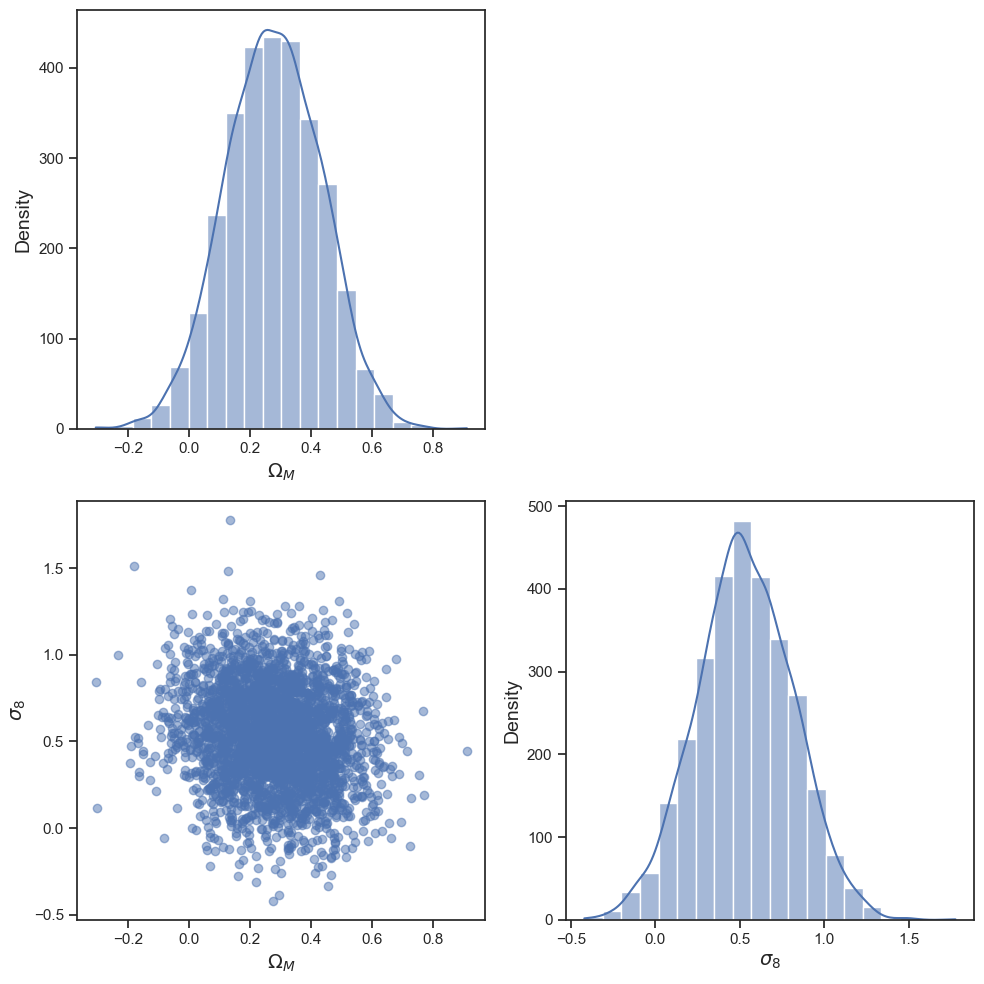

In [148]:
# Create the test dataset
dset_test = input_fn_omega_sigma8(mode="test")
iterator = iter(dset_test)
batch = iterator.get_next()

nsamples = 3000
nplots = 1
# Generate samples from the model
for b in range(nplots):
    # Lists to store samples
    omega_pred_samples = []
    sigma8_pred_samples = []
    for i in range(nsamples):
        samples = mdn_multivariate(batch[0]).sample()[b]
        omega_pred_samples.append(samples[0])
        sigma8_pred_samples.append(samples[1])

    # Combine the samples into a matrix
    samples_matrix = np.vstack((omega_pred_samples, sigma8_pred_samples)).T

    # Create a corner plot
    sns.set(style="ticks")
    corner_labels = [r"$\Omega_M$", r"$\sigma_8$"]
    plt.figure(figsize=(10, 10))

    # Create scatter plots for the lower diagonal
    for i in range(2):
        for j in range(i + 1):
            plt.subplot(2, 2, i * 2 + j + 1)
            if i == j:
                sns.histplot(samples_matrix[:, i], bins=20, kde=True, color="b")
                plt.xlabel(corner_labels[i], fontsize=14)
                plt.ylabel("Density", fontsize=14)
            else:
                plt.scatter(
                    samples_matrix[:, j], samples_matrix[:, i], color="b", alpha=0.5
                )
                plt.xlabel(corner_labels[j], fontsize=14)
                plt.ylabel(corner_labels[i], fontsize=14)

    plt.tight_layout()
    plt.show()